In [1]:
import folium    # visualize spatial data in an interactive manner

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library based on matplotlib
import geopandas # working with geospatial data in python easier
import missingno as msn
import matplotlib.pyplot as plt

from folium.plugins import HeatMap
from folium import plugins
from collections import namedtuple
from shapely.geometry import Point

!pip install basemap
!pip install basemap-data
from mpl_toolkits.basemap import Basemap
from IPython.display import HTML
from matplotlib.ticker import FuncFormatter
from pylab import rcParams
from matplotlib import animation
from matplotlib import cm
import matplotlib as mpl
import datetime

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.6/864.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 31.5 MB/s eta 0:00:00


In [2]:
Traffic_path = '/kaggle/input/ph-datasets/Ph_Datasets/Traffic, Investigations _ Other/'
Crash_path = '/kaggle/input/ph-datasets/Ph_Datasets/Crashes/'

df_crash_info = pd.read_csv(Crash_path+'crash_info_general.csv')
df_crash_info = df_crash_info[df_crash_info.columns[1:]]
cond = (df_crash_info['DEC_LAT'].isna())|(df_crash_info['DEC_LONG'].isna())
df_crash_info = df_crash_info.loc[~cond,:]
df_crash_info = df_crash_info.rename(columns={'DEC_LAT':"lat","DEC_LONG":"lng"})

df_flag = pd.read_csv(Crash_path+'crash_info_flag_variables.csv')
df_flag = df_flag.merge(df_crash_info[['CRN','lat','lng','fips','CRASH_MONTH','CRASH_YEAR','DAY_OF_WEEK']],on=['CRN'])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (97,98,99) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
lon = df_crash_info['lat'].astype(float)
lat = df_crash_info['lng'].astype(float)
avgLon = sum(lon)/len(lon)
avgLat = sum(lat)/len(lat)

crash_map = folium.Map(location=[avgLat, avgLon], 
                       tiles = "Stamen Toner",
                      zoom_start = 11)

# Add data for heatmp 
data_heatmap = df_crash_info
data_heatmap = data_heatmap[['lat','lng']]
data_heatmap = [[row['lat'],row['lng']] for index, row in data_heatmap.iterrows()]
HeatMap(data_heatmap, radius=10).add_to(crash_map)

crash_map

<AxesSubplot:>

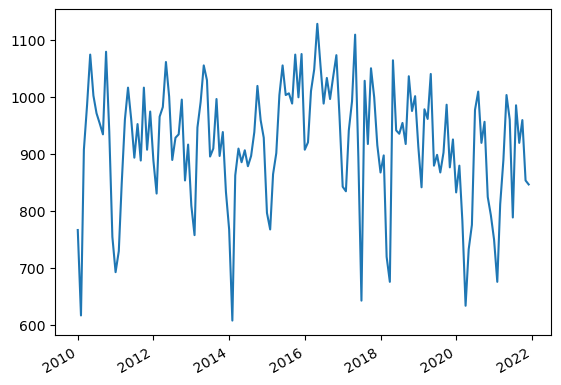

In [4]:
df_time = df_flag.groupby(['CRASH_MONTH','CRASH_YEAR']).CRN.count().reset_index()
dt = []
for i in range(len(df_time)):
    temp = (str(df_time.loc[i,'CRASH_YEAR'])+('-0' if len(str(df_time.loc[i,'CRASH_MONTH']))==1 else "-")+str(df_time.loc[i,'CRASH_MONTH']))
    dt.append(datetime.datetime.strptime(temp,'%Y-%m'))
    
df_time.index = dt
df_time.CRN.plot()

<AxesSubplot:xlabel='CRASH_YEAR'>

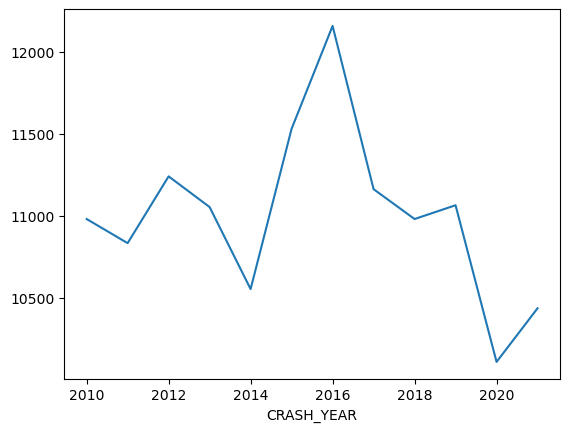

In [5]:
df_time = df_flag.groupby(['CRASH_YEAR']).CRN.count().reset_index()
df_time.index = df_time.CRASH_YEAR
df_time.CRN.plot()

In [6]:
df_path = pd.read_csv(Crash_path+'crash_info_roadway.csv')
df_path = df_path.drop_duplicates('CRN',keep='last')
df_path.ADJ_RDWY_SEQ.value_counts()
road_list = [i for i in df_path.STREET_NAME.value_counts().index.to_list()[:11] if i != 'RAMP RD']

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


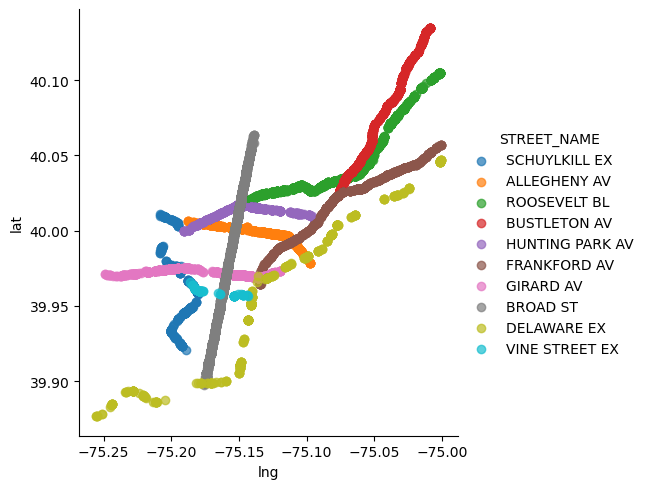

In [7]:
df_path = df_path.merge(df_flag[['CRN','INTERSECTION','lat','lng']],on='CRN')
sns.lmplot(x='lng', y='lat',  hue='STREET_NAME', 
           data=df_path[(df_path.lat>39.8)&(df_path.lng<-75)
                        &(df_path.STREET_NAME.isin(road_list))
                       &(df_path.INTERSECTION==1)],
           fit_reg=False, scatter_kws={'alpha':0.7})

Aggravated Assault Firearm


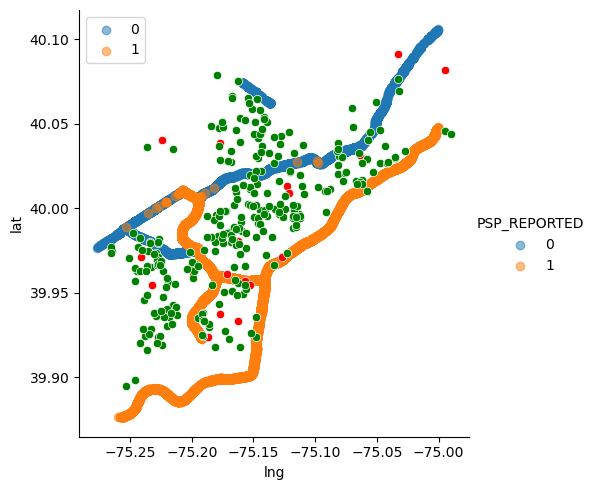

Aggravated Assault No Firearm


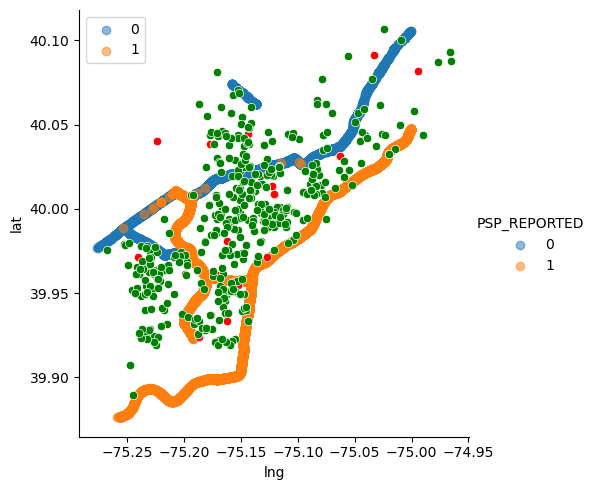

All Other Offenses


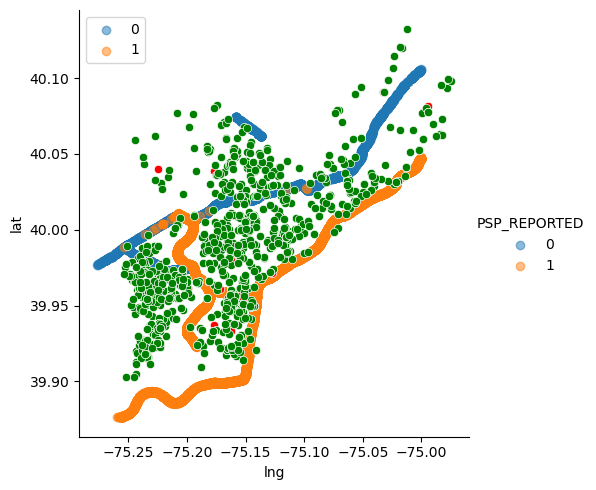

Arson


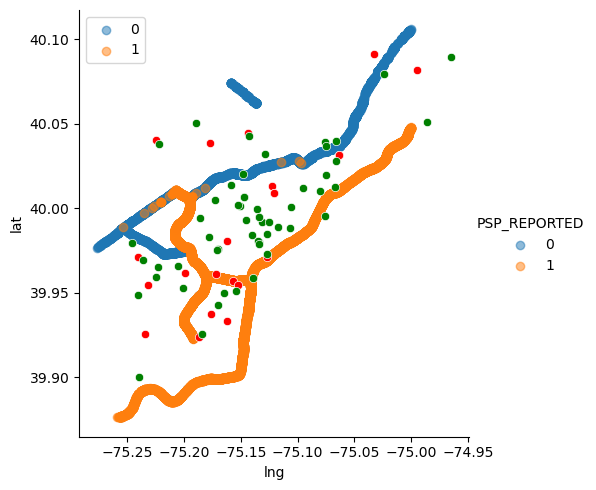

Burglary Non-Residential


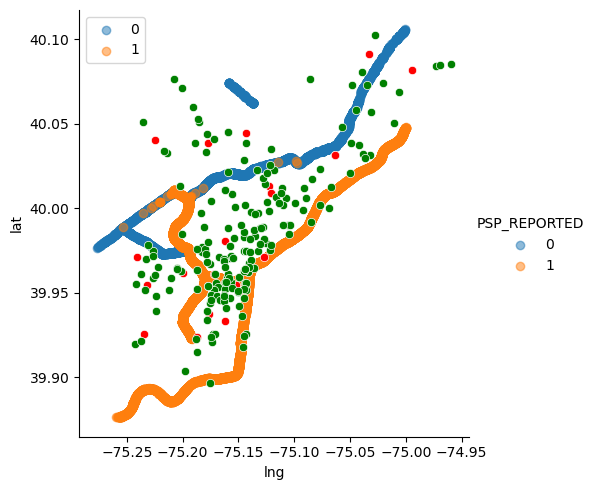

Burglary Residential


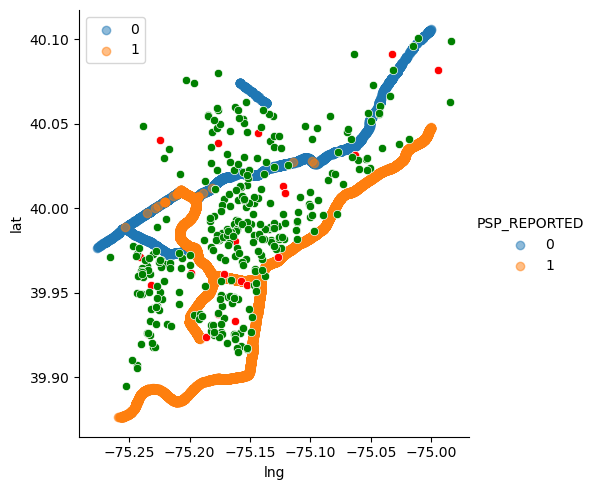

DRIVING UNDER THE INFLUENCE


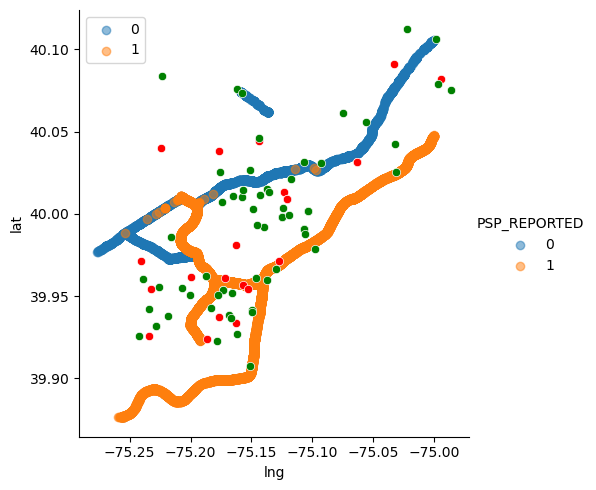

Disorderly Conduct


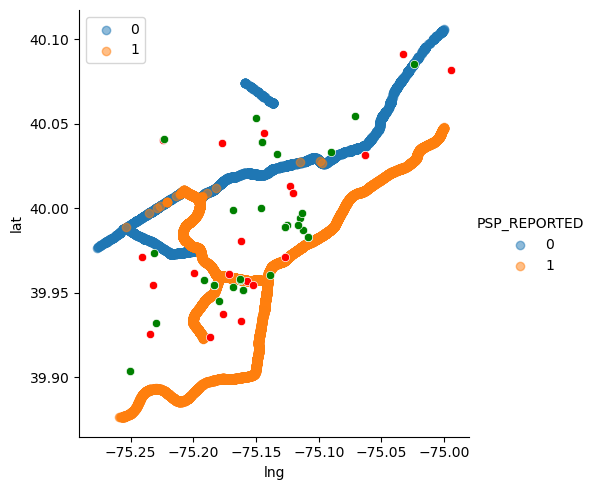

Embezzlement


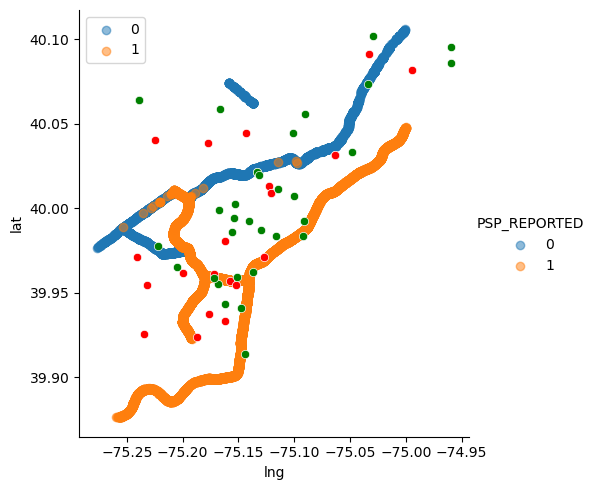

Forgery and Counterfeiting


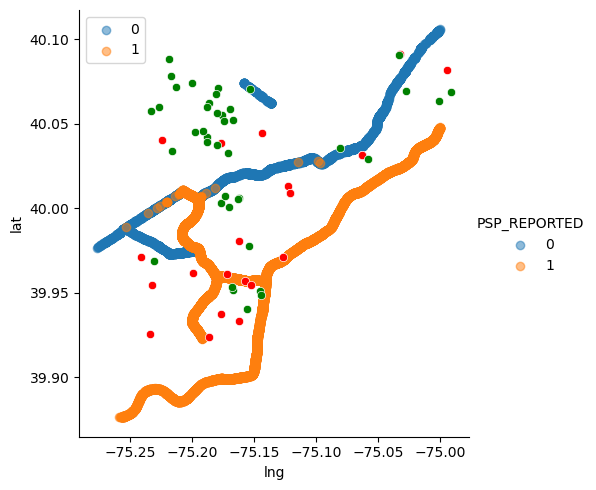

Fraud


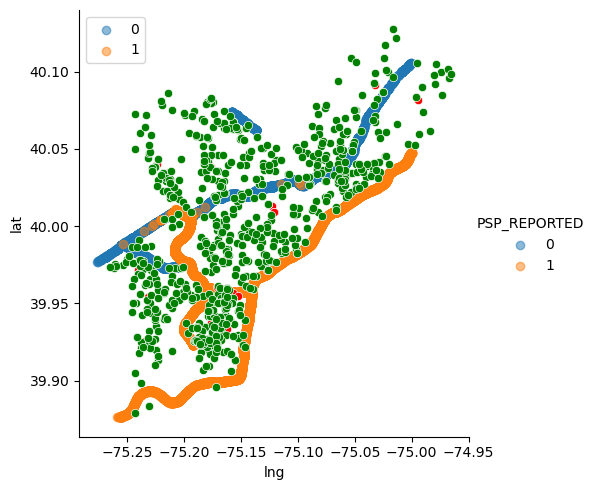

Homicide - Criminal


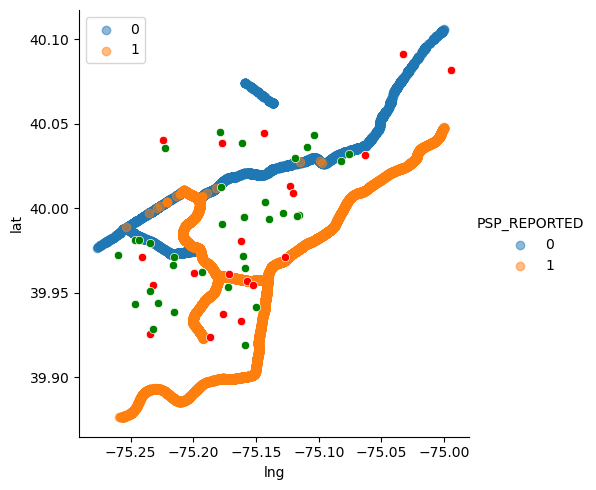

Homicide - Criminal 


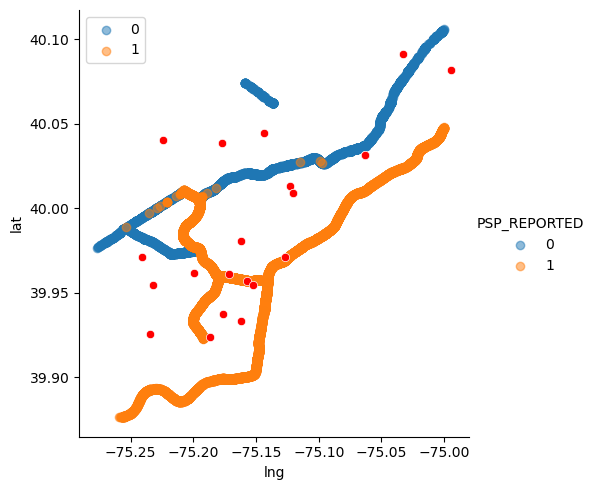

Liquor Law Violations


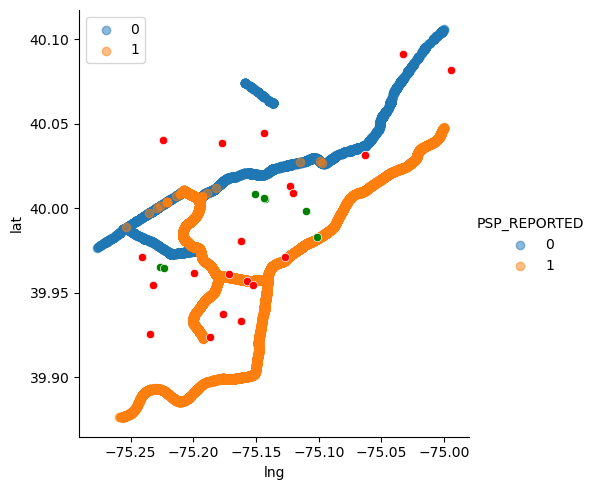

Motor Vehicle Theft


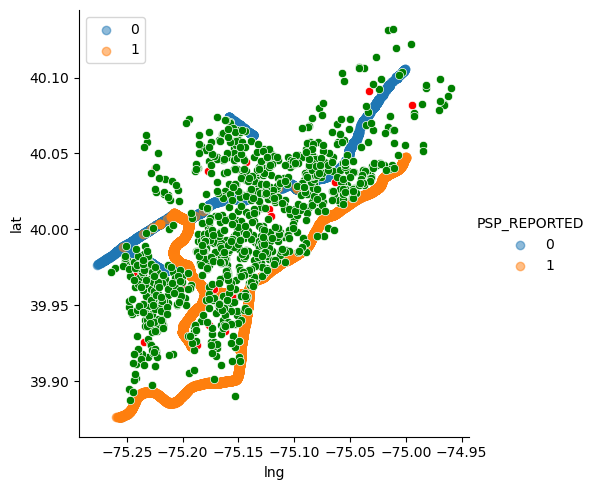

Narcotic / Drug Law Violations


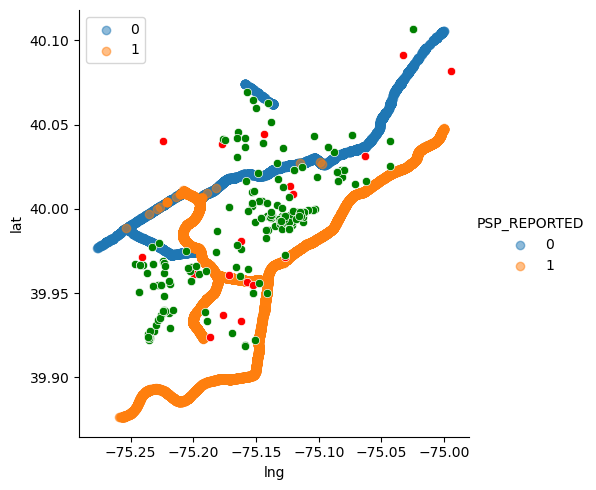

Offenses Against Family and Children


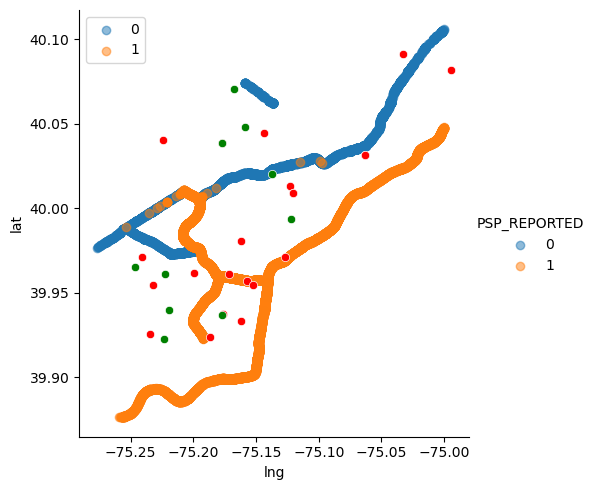

Other Assaults


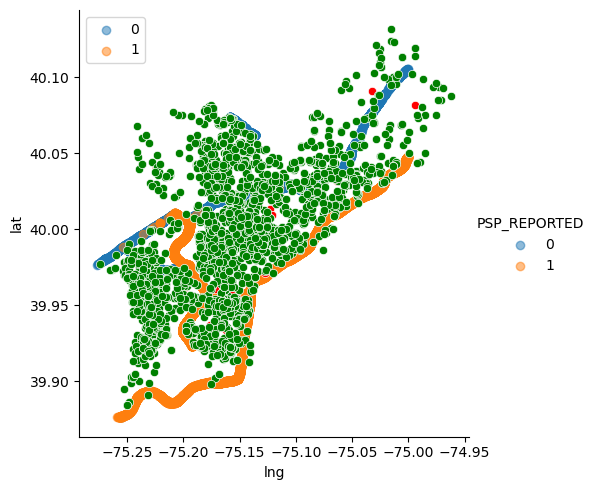

Other Sex Offenses (Not Commercialized)


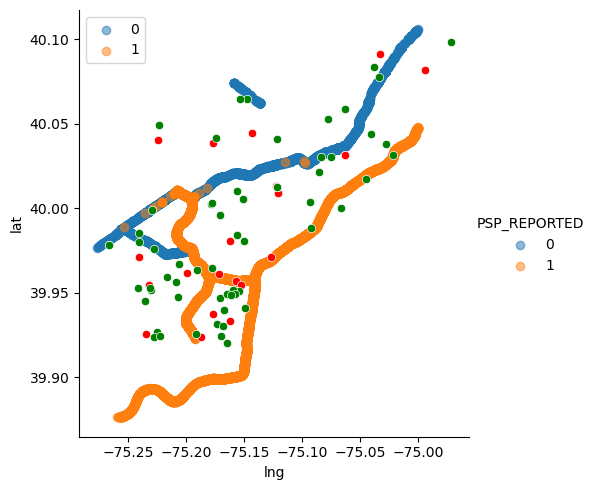

Prostitution and Commercialized Vice


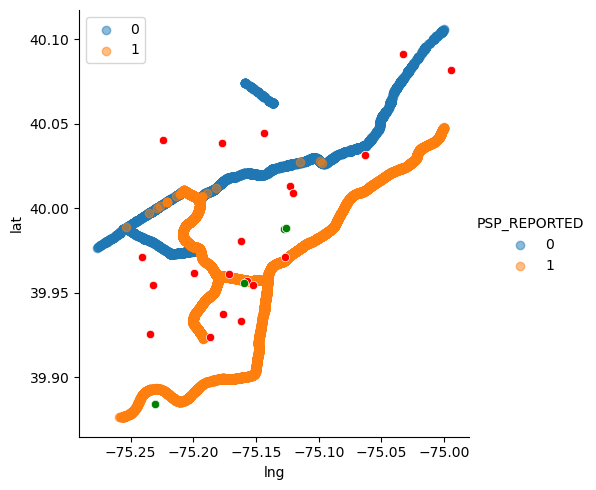

Public Drunkenness


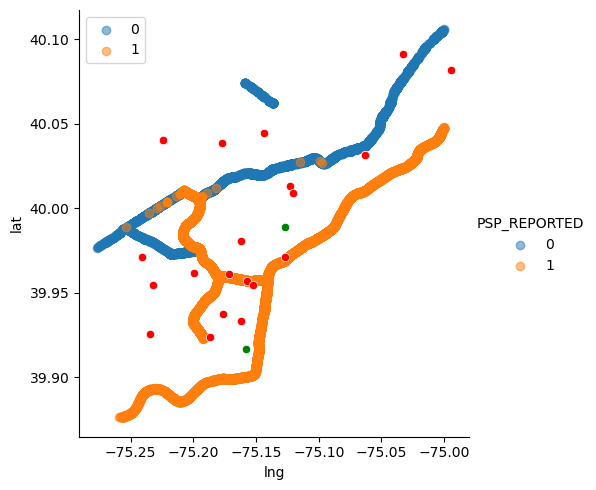

Rape


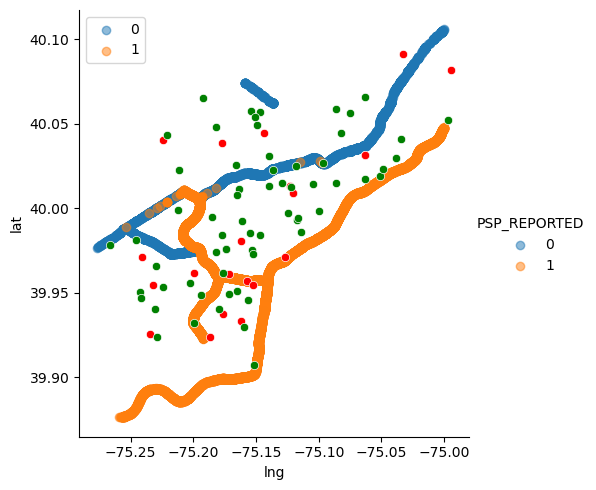

Receiving Stolen Property


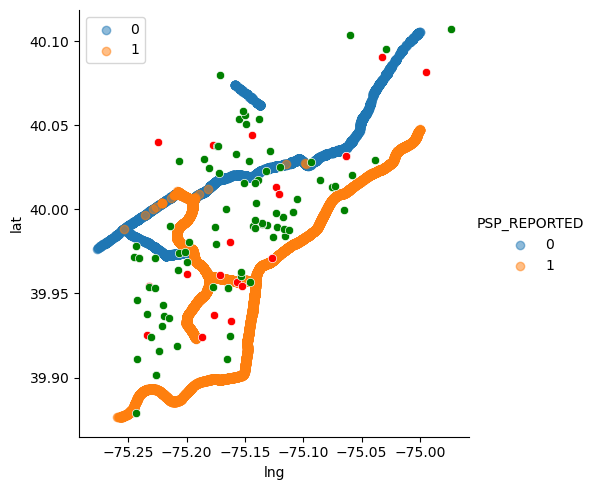

Robbery Firearm


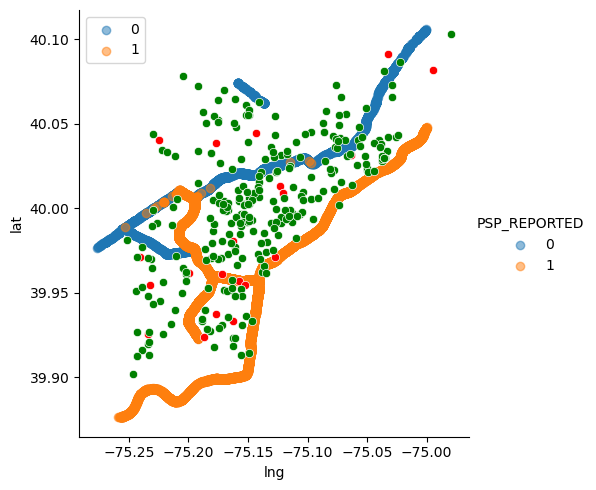

Robbery No Firearm


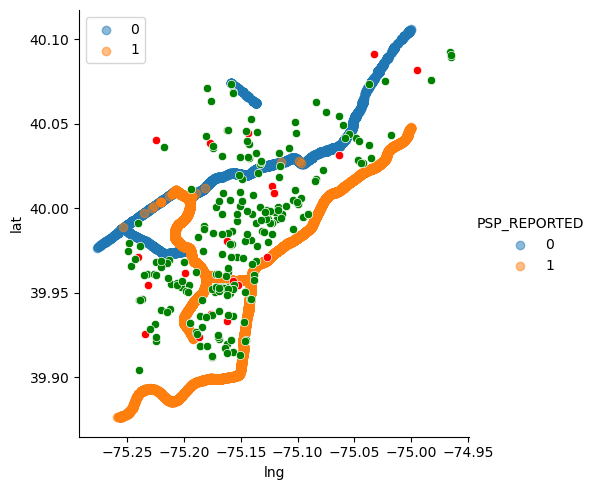

Theft from Vehicle


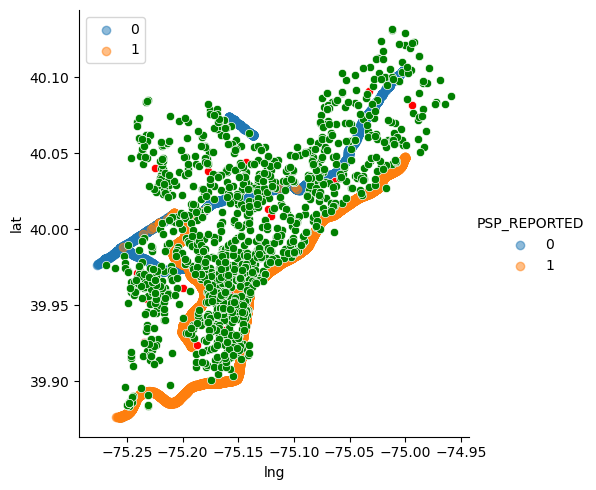

Thefts


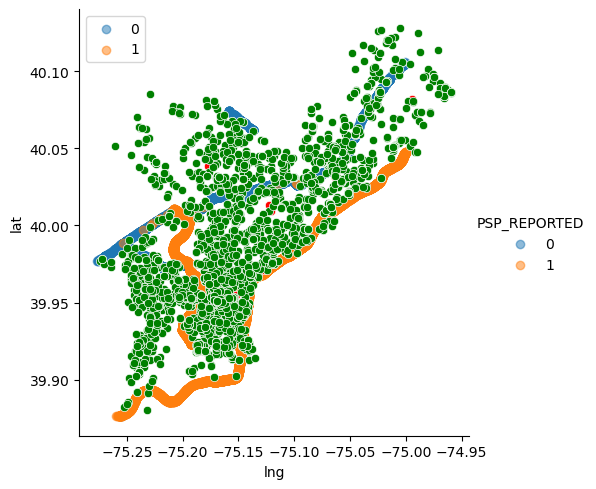

Vandalism/Criminal Mischief


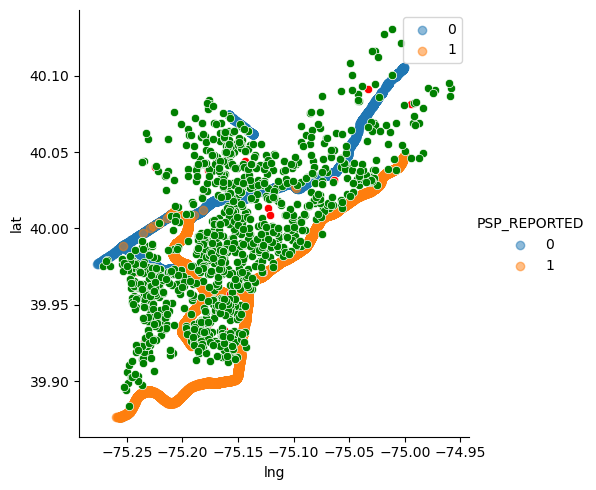

Weapon Violations


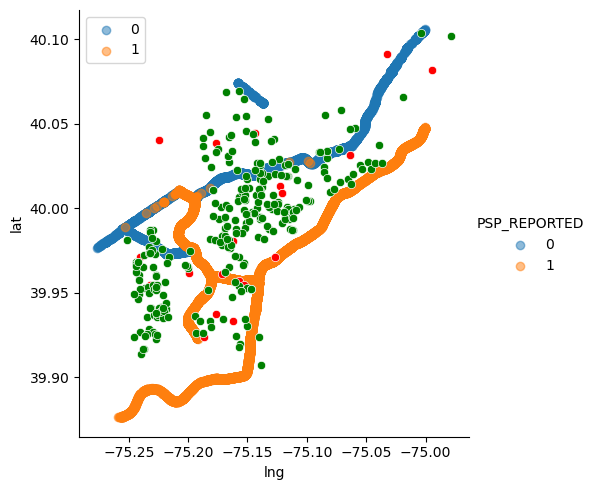

Empty DataFrame
Columns: []
Index: []

In [8]:
df_crime = pd.read_csv(Traffic_path+'crimes.csv')
df_crime['month'] = df_crime.dispatch_date.apply(lambda x: x[:7])
df_police = pd.read_csv(Traffic_path+'police_stations.csv')
def plot_with_main_network(df):
    print(df.text_general_code.iloc[0])
    lm = sns.lmplot(x='lng', y='lat',  hue='PSP_REPORTED', 
           data=df_flag[(df_flag.lat>39.8)&(df_flag.lng<-75.0)&
                        (df_flag.CORE_NETWORK==1)],
           fit_reg=False, scatter_kws={'alpha':0.5})
    sns.scatterplot(x='lng', y='lat',data=df_police,ax=lm.ax,color='red')
    sns.scatterplot(x='lng', y='lat',data=df,ax=lm.ax,color='green')
    plt.show()
df_crime[df_crime.month=='2022-09'].groupby('text_general_code').apply(plot_with_main_network)

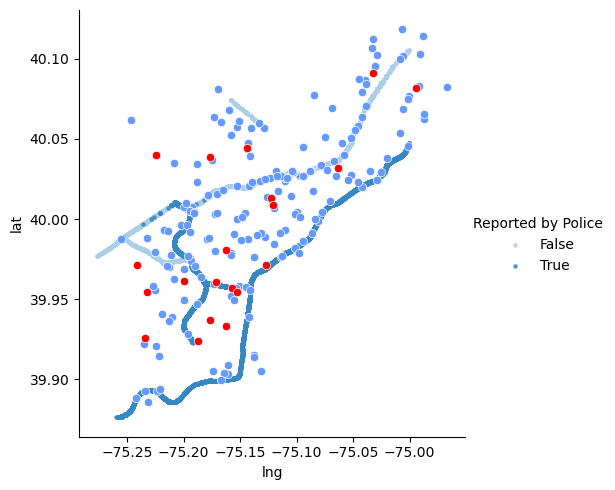

In [9]:
df_flag['Reported by Police'] = df_flag.PSP_REPORTED.astype(bool)
lm = sns.lmplot(x='lng', y='lat',  hue='Reported by Police', 
           data=df_flag[(df_flag.lat>39.8)&(df_flag.lng<-75.0)&
                        (df_flag.CORE_NETWORK==1)],
           fit_reg=False, scatter_kws={'alpha':0.8,"s": 5}, palette='Blues')
sns.scatterplot(x='lng', y='lat',data=df_flag[(df_flag.FATAL==True)&(df_flag.SPEEDING==True)],ax=lm.ax,color=(0.4, 0.6, 1))
sns.scatterplot(x='lng', y='lat',data=df_police,ax=lm.ax,color='red')
#plt.show()
plt.gca().legend_.remove()

plt.show()

In [10]:
df_flag = df_flag.merge(df_path[['CRN','STREET_NAME']])
df_test = df_flag[['CRN','AGGRESSIVE_DRIVING','ALCOHOL_RELATED','DRINKING_DRIVER','MOTORCYCLE',"SPEEDING","STREET_NAME","FATAL"]]
df_test[df_test.STREET_NAME=='ROOSEVELT BL'].describe()

CRN  AGGRESSIVE_DRIVING  ALCOHOL_RELATED  DRINKING_DRIVER  \
count  4.652000e+03         4652.000000      4652.000000      4652.000000   
mean   2.014630e+09            0.578246         0.048796         0.045357   
std    3.336075e+06            0.493893         0.215465         0.208108   
min    2.010012e+09            0.000000         0.000000         0.000000   
25%    2.012028e+09            0.000000         0.000000         0.000000   
50%    2.014065e+09            1.000000         0.000000         0.000000   
75%    2.017127e+09            1.000000         0.000000         0.000000   
max    2.022012e+09            1.000000         1.000000         1.000000   

        MOTORCYCLE     SPEEDING        FATAL  
count  4652.000000  4652.000000  4652.000000  
mean      0.027300     0.067928     0.021926  
std       0.162974     0.251649     0.146458  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000

In [11]:
df_test[df_test.STREET_NAME!='ROOSEVELT BL'].describe()

CRN  AGGRESSIVE_DRIVING  ALCOHOL_RELATED  DRINKING_DRIVER  \
count  1.274570e+05       127457.000000    127457.000000    127457.000000   
mean   2.015636e+09            0.487772         0.051821         0.046722   
std    3.391039e+06            0.499852         0.221667         0.211043   
min    2.010001e+09            0.000000         0.000000         0.000000   
25%    2.013022e+09            0.000000         0.000000         0.000000   
50%    2.016015e+09            0.000000         0.000000         0.000000   
75%    2.018137e+09            1.000000         0.000000         0.000000   
max    2.022066e+09            1.000000         1.000000         1.000000   

          MOTORCYCLE       SPEEDING          FATAL  
count  127457.000000  127457.000000  127457.000000  
mean        0.026558       0.030599       0.008411  
std         0.160788       0.172228       0.091324  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000

In [12]:
import scipy.stats as stats
def KS_test(sample1,sample2):

    # Perform KS test
    statistic, p_value = stats.ks_2samp(sample1, sample2)

    # Print results
    print("KS statistic:", statistic)
    print("p-value:", p_value)

    # Set significance level (alpha)
    alpha = 0.05

    # Interpret results
    if p_value > alpha:
        print("Samples are likely from the same distribution (Fail to reject null hypothesis)")
    else:
        print("Samples are likely from different distributions (Reject null hypothesis)")

In [13]:
KS_test(df_test[df_test.STREET_NAME=='ROOSEVELT BL'].SPEEDING
        ,df_test[df_test.STREET_NAME!='ROOSEVELT BL'].SPEEDING)

KS statistic: 0.0373292181941407
p-value: 7.190159792347432e-06
Samples are likely from different distributions (Reject null hypothesis)


In [14]:
KS_test(df_test[df_test.STREET_NAME=='ROOSEVELT BL'].FATAL
        ,df_test[df_test.STREET_NAME!='ROOSEVELT BL'].FATAL)

KS statistic: 0.013515373630198169
p-value: 0.3819045845689113
Samples are likely from the same distribution (Fail to reject null hypothesis)


In [15]:
df = df_crash_info[['CRN','HOUR_OF_DAY']].merge(df_path[['CRN','STREET_NAME']],on='CRN').merge(df_flag[['CRN','SPEEDING','MOTORCYCLE','FATAL']],on='CRN')
df = df[(df.FATAL==1)&(df.STREET_NAME=='ROOSEVELT BL')]

daytime = {}
for i in range(24):
    if i >= 6 and i < 12:
        daytime[i] = 'morning'
    elif i >= 12 and i < 18:
        daytime[i] = 'afternoon'
    elif (i >= 18 and i <= 24) or (i >= 0 and i < 6):
        daytime[i] = 'night'
daytime[99] = 'Dont Know'

#df['HOURS_OF_DAY'] = df.HOURS_OF_DAY.map(daytime)
df['time'] = df.HOUR_OF_DAY.map(daytime)

In [16]:
df['time'] = df.HOUR_OF_DAY.map(daytime)

In [17]:
df[df.SPEEDING==1].time.value_counts()

night        20
morning       3
afternoon     1
Name: time, dtype: int64

In [18]:
df[df.MOTORCYCLE==1].time.value_counts()

night    5
Name: time, dtype: int64

In [19]:
from scipy.stats import chi2_contingency
def chi2_test(name1,name2):
    m11 = len(df_test[(df_test[name1]==1)&(df_test[name2]==1)])
    m12 = len(df_test[(df_test[name1]!=1)&(df_test[name2]==1)])
    m21 = len(df_test[(df_test[name1]==1)&(df_test[name2]!=1)])
    m22 = len(df_test[(df_test[name1]!=1)&(df_test[name2]!=1)])
    d = np.array([[m11,m12], [m21,m22]])
    print(chi2_contingency(d))

In [20]:
chi2_test('FATAL','SPEEDING')

(712.4444284471705, 5.883220642103901e-157, 1, array([[3.74659107e+01, 4.17853409e+03],
       [1.13653409e+03, 1.26756466e+05]]))


In [21]:
chi2_test('FATAL','MOTORCYCLE')

(1253.6897208573707, 1.3098917606751601e-274, 1, array([[3.12097435e+01, 3.48079026e+03],
       [1.14279026e+03, 1.27454210e+05]]))


In [22]:
chi2_test('SPEEDING','MOTORCYCLE')

(252.86128357237666, 6.17544074791432e-57, 1, array([[1.12078602e+02, 3.39992140e+03],
       [4.10392140e+03, 1.24493079e+05]]))
